### Our Tasks & Output Data Analysis

In [683]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import t, norm

# reset display options
pd.reset_option("all")
# width of the display to max
pd.set_option('display.width', 1000)

def load_and_clean_queue_data(folder_path: str, queue_type: str):
    """Loads and processes bicycle or dock queue files (A to D)"""
    dfs = []
    for station in ['A', 'B', 'C', 'D']:
        filename = f"{queue_type}_queue_{station}.csv"
        filepath = Path(folder_path) / filename
        if filepath.exists():
            df = pd.read_csv(filepath)
            df["station"] = station
            df["queue_type"] = queue_type
            df["wait_time"] = df["curr_WaitTime"] - df["prev_WaitTime"]
            dfs.append(df[["replication_no", "id", "station", "queue_type", "wait_time"]])
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def get_current_bicycle_and_dock_count(folder_path: str):
    """Get the current bicycle and dock count for each station"""
    docksize_file = Path(folder_path) / "docksize.csv"
    bicycles_count = 0
    docks_count = 0
    if docksize_file.exists():
        docksize_df = pd.read_csv(docksize_file)
        # 1st row skip header = availablebicycles + available docks
        docksize_df = docksize_df.iloc[1:]
        bicycles_count = int(docksize_df.iloc[0]["availablebicycles"]) + 1
        docks_count = int(docksize_df.iloc[0]["availabledock"]) + int(docksize_df.iloc[0]["availablebicycles"])
    return bicycles_count, docks_count

# Combine bicycle and dock queue data
def combine_all_queues(folder_path: str):
    bicycle_df = load_and_clean_queue_data(folder_path, "bicycle")
    dock_df = load_and_clean_queue_data(folder_path, "dock")
    combined = pd.concat([bicycle_df, dock_df], ignore_index=True)
    return combined

# Compute average waiting time per tourist per replication
def compute_per_tourist_avg_per_replication(wait_data: pd.DataFrame):
    non_zero = wait_data[wait_data["wait_time"] > 0]

    # Compute mean wait time over non-zero wait times
    avg_wait = non_zero.groupby(["id", "replication_no"])["wait_time"].mean().reset_index(name="avg_wait_time_per_tourist")

    # Now make sure all tourists (even those with only zeros) are present
    all_ids = wait_data[["id", "replication_no"]].drop_duplicates()
    result = all_ids.merge(avg_wait, on=["id", "replication_no"], how="left")

    # Fill NaN with 0 for those who had all wait_time == 0
    result["avg_wait_time_per_tourist"] = result["avg_wait_time_per_tourist"].fillna(0)

    return result

# Compute average waiting time per tourist per replication per station
def compute_per_tourist_avg_per_replication_per_station(wait_data: pd.DataFrame):
    return wait_data.groupby(["id", "replication_no", "station"])["wait_time"].mean().reset_index(name="avg_wait_time_per_tourist")

# Plot histogram and CDF
def plot_wait_distributions(per_tourist_df: pd.DataFrame):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(per_tourist_df["avg_wait_time_per_tourist"], bins=20, kde=True)
    plt.axvline(15, color='red', linestyle='--', label='Happy threshold (15 mins)')
    plt.title("Histogram of Average Wait Time per Tourist")
    plt.xlabel("Average Wait Time (minutes)")
    plt.ylabel("Number of Tourists")
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.ecdfplot(per_tourist_df["avg_wait_time_per_tourist"])
    plt.axvline(15, color='red', linestyle='--', label='Happy threshold (15 mins)')
    plt.title("CDF of Average Wait Time per Tourist")
    plt.xlabel("Average Wait Time (minutes)")
    plt.ylabel("Proportion of Tourists")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Compute per replication stats
def compute_per_replication_stats(wait_data: pd.DataFrame) -> pd.DataFrame:
    """Returns average waiting time, total arrival count, mean number of tourists waiting per replication"""
    grouped = wait_data.groupby("replication_no")
    avg_wait_time = grouped["avg_wait_time_per_tourist"].mean()
    total_arrival_count = grouped["id"].count()
    tourists_waiting = (
        grouped["avg_wait_time_per_tourist"]
        .apply(lambda x: (x > 0).sum())
    )
    mean_number_of_tourists_waiting = tourists_waiting / total_arrival_count
    
    result = pd.concat([
        total_arrival_count.rename("total_arrival_count"),
        mean_number_of_tourists_waiting.rename("mean_tourists_waiting"),
        avg_wait_time.rename("avg_wait_time_per_tourist"),
    ], axis=1)

    return result

# Compute confidence interval
def compute_confidence_interval(avg_waits: pd.Series, conf: float = 0.95, print_stats: bool = True):
    n = len(avg_waits)
    mean_x = avg_waits.mean()
    std_s = avg_waits.std(ddof=1)  # sample std dev
    alpha = 1 - conf

    # Degrees of freedom
    df = n - 1

    # t critical value for 95% CI
    t_crit = t.ppf(1 - alpha/2, df)

    # Margin of error
    margin = t_crit * (std_s / np.sqrt(n))

    # Confidence Interval
    conf_interval = (max(0, mean_x - margin), mean_x + margin)

    if print_stats:
        print(f"Sample Mean: {mean_x}")
        print(f"Sample Std Dev: {std_s}")
        print(f"t-critical (95%): {t_crit}")
        print(f"Margin of Error: {margin}")
        print(f"Confidence Interval: {conf_interval}")
    return conf_interval, mean_x, std_s, t_crit, margin

def compute_per_tourist_total_wait_time(data: pd.DataFrame):
    return data.groupby(["id", "replication_no"])["wait_time"].sum().reset_index(name="total_wait_time")

/var/folders/gt/d0m_mbpj3_s59cfmmr0pkgg80000gn/T/ipykernel_18787/3791650698.py:9: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


In [684]:
og_data_path = f"./data_80_80"
data_path = f"./data"

bicycle_count, dock_count = get_current_bicycle_and_dock_count(data_path)
print(f"Our System Total Bicycles: {bicycle_count}")
print(f"Our System Total Docks: {dock_count}")

Our System Total Bicycles: 80
Our System Total Docks: 80


In [685]:
# OG Bicycle & Dock Queue Data
og_df_bicycle_queue = load_and_clean_queue_data(og_data_path, "bicycle")
og_df_bicycle_queue.head()

# Bicycle Queue Data
df_bicycle_queue = load_and_clean_queue_data(data_path, "bicycle")
df_bicycle_queue.head()

,replication_no,id,station,queue_type,wait_time
0,1,11,A,bicycle,0.0
1,1,16,A,bicycle,0.0
2,1,21,A,bicycle,0.0
3,1,24,A,bicycle,0.0
4,1,14,A,bicycle,0.0


In [686]:
# unique values of replication_no
df_bicycle_queue["replication_no"].unique()

array([1, 2, 3, 4, 5, 6])

In [687]:
df_bicycle_queue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13147 entries, 0 to 13146
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   replication_no  13147 non-null  int64  
 1   id              13147 non-null  int64  
 2   station         13147 non-null  object 
 3   queue_type      13147 non-null  object 
 4   wait_time       13147 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 513.7+ KB


In [688]:
# OG Dock Queue Data
og_df_dock_queue = load_and_clean_queue_data(og_data_path, "dock")
og_df_dock_queue.head()

# Dock Queue Data
df_dock_queue = load_and_clean_queue_data(data_path, "dock")
df_dock_queue.head()

,replication_no,id,station,queue_type,wait_time
0,1,14,A,dock,0.0
1,1,22,A,dock,0.0
2,1,13,A,dock,0.0
3,1,32,A,dock,0.0
4,1,20,A,dock,0.0


In [689]:
df_dock_queue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   replication_no  12811 non-null  int64  
 1   id              12811 non-null  int64  
 2   station         12811 non-null  object 
 3   queue_type      12811 non-null  object 
 4   wait_time       12811 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 500.6+ KB


In [690]:
# OG Data
og_data = pd.concat([og_df_bicycle_queue, og_df_dock_queue])
og_data.head()

# Our Model Data
data = pd.concat([df_bicycle_queue, df_dock_queue])
data.head()

,replication_no,id,station,queue_type,wait_time
0,1,11,A,bicycle,0.0
1,1,16,A,bicycle,0.0
2,1,21,A,bicycle,0.0
3,1,24,A,bicycle,0.0
4,1,14,A,bicycle,0.0


In [691]:
# tourist 1 & replication 2
data[(data["id"] == 11) & (data["replication_no"] == 1)]

,replication_no,id,station,queue_type,wait_time
0,1,11,A,bicycle,0.000000
3340,1,11,B,bicycle,0.000000
6696,1,11,C,bicycle,0.000000
3229,1,11,B,dock,1.644738
6472,1,11,C,dock,11.707794
9661,1,11,D,dock,27.737416


### Question 1:
The average waiting time for renting or returning a bicycle at each station? If tourists should not wait more than one hour in total (both for renting bikes and returning them), is the current system satisfactory?

In [692]:
# Per station analysis
per_tourist_per_station_df = compute_per_tourist_avg_per_replication_per_station(og_data)
per_tourist_per_station_df.head()

,id,replication_no,station,avg_wait_time_per_tourist
0,1,2,A,0.000000
1,1,2,B,2.998321
2,1,2,C,0.000000
3,1,2,D,0.000000
4,1,3,A,0.000000


In [693]:
# Any tourist should not wait more than 1 hour in total (both for renting bikes and returning them)

per_tourist_total_wait_time_df = compute_per_tourist_total_wait_time(og_data)
per_tourist_total_wait_time_df

,id,replication_no,total_wait_time
0,1,2,5.996642
1,1,3,0.000000
2,1,4,0.000000
3,1,5,9.925591
4,1,6,2.441270
...,...,...,...
38657,827,46,0.000000
38658,828,25,0.000000
38659,828,38,0.000000
38660,829,25,0.000000


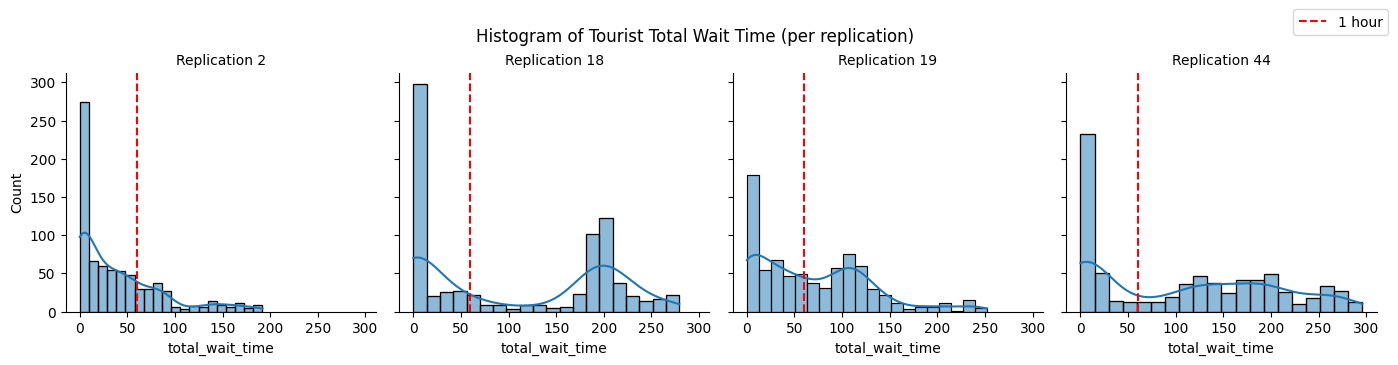

In [694]:
# Let's take few random replications and plot the histogram of tourist total wait time
# random 4 replications
random_replications = per_tourist_total_wait_time_df["replication_no"].sample(4).values
sample_df = per_tourist_total_wait_time_df[per_tourist_total_wait_time_df["replication_no"].isin(random_replications)]

def hist_with_vline(data, color=None, **kwargs):
    ax = plt.gca()
    sns.histplot(data["total_wait_time"], bins=20, kde=True, ax=ax, color=color)
    ax.axvline(60, color='red', linestyle='--', label='1 hour')

# Create and map
g = sns.FacetGrid(sample_df, col="replication_no", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(hist_with_vline)

# Add a 1 hour legend manually
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1, 1.05))

# Titles and layout
g.set_titles("Replication {col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Histogram of Tourist Total Wait Time (per replication)")

plt.show()


In [695]:
#### Confidence Interval
# Get confidence, on yes there is some tourist waiting time >= 1 hour

# Get max total waiting time by tourist per replication
max_total_time_per_tourist_per_replication = per_tourist_total_wait_time_df.groupby(["replication_no"])["total_wait_time"].max().reset_index(name="max_total_wait_time")
max_total_time_per_tourist_per_replication.head()

# Calculate confidence interval for max total waiting time at 95% confidence level
(
    confidence_interval_max_total_wait_time, 
    mean_x_max_total_wait_time, 
    std_s_max_total_wait_time, 
    t_crit_max_total_wait_time, 
    margin_max_total_wait_time
) = compute_confidence_interval(max_total_time_per_tourist_per_replication["max_total_wait_time"], conf=0.95, print_stats=False)

print("+++--- Confidence Interval for Total Waiting Time ---+++")
print(f"    Sample Mean: {mean_x_max_total_wait_time} mins (i.e. {round(mean_x_max_total_wait_time/60, 2)} hrs)")
print(f"    Sample Std Dev: {std_s_max_total_wait_time} mins (i.e. {round(std_s_max_total_wait_time/60, 2)} hrs)")
print(f"    t-critical (95%): {t_crit_max_total_wait_time}")
print(f"    Margin of Error: {margin_max_total_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_max_total_wait_time} (mins) (i.e. {round(confidence_interval_max_total_wait_time[0]/60, 2)} hrs to {round(confidence_interval_max_total_wait_time[1]/60, 2)} hrs)")
print("+++--- End of Confidence Interval for Total Waiting Time ---+++")

+++--- Confidence Interval for Total Waiting Time ---+++
    Sample Mean: 270.38714433999996 mins (i.e. 4.51 hrs)
    Sample Std Dev: 72.83155541204395 mins (i.e. 1.21 hrs)
    t-critical (95%): 2.0095752371292392
    Margin of Error: 20.698499028965898 mins
    Confidence Interval: (249.68864531103407, 291.08564336896586) (mins) (i.e. 4.16 hrs to 4.85 hrs)
+++--- End of Confidence Interval for Total Waiting Time ---+++


In [696]:
# Check if there is any tourist waiting time >= 1 hour
is_any_tourist_waiting_more_than_1_hour = per_tourist_total_wait_time_df["total_wait_time"].gt(60).any()
is_any_tourist_waiting_more_than_1_hour

print("+++--- Conclusion ---+++")
if is_any_tourist_waiting_more_than_1_hour:
    print("Yes, there are tourists waiting more than 1 hour in total (both for renting bikes and returning them).")
    print("*** So, System is not satisfactory. ***")
else:
    print("No, there are no tourists waiting more than 1 hour in total (both for renting bikes and returning them).")
    print("*** So, System is satisfactory. ***")

+++--- Conclusion ---+++
Yes, there are tourists waiting more than 1 hour in total (both for renting bikes and returning them).
*** So, System is not satisfactory. ***


In [697]:
# The average waiting time for renting or returning a bicycle at each station?

# Station A
station_a_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "A"]
station_a_per_replication_stats = compute_per_replication_stats(station_a_df)
print("-" * 100)
print("Station A Per Replication Stats:")
print("-" * 100)
print(station_a_per_replication_stats)
# Station B
station_b_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "B"]
station_b_per_replication_stats = compute_per_replication_stats(station_b_df)
print("-" * 100)
print("Station B Per Replication Stats:")
print("-" * 100)
print(station_b_per_replication_stats.head())
# Station C
station_c_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "C"]
station_c_per_replication_stats = compute_per_replication_stats(station_c_df)
print("-" * 100)
print("Station C Per Replication Stats:")
print("-" * 100)
print(station_c_per_replication_stats.head())
# Station D
station_d_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "D"]
station_d_per_replication_stats = compute_per_replication_stats(station_d_df)
print("-" * 100)
print("Station D Per Replication Stats:")
print("-" * 100)
print(station_d_per_replication_stats.head())


----------------------------------------------------------------------------------------------------
Station A Per Replication Stats:
----------------------------------------------------------------------------------------------------
                total_arrival_count  mean_tourists_waiting  avg_wait_time_per_tourist
replication_no                                                                       
1                               690               0.000000                   0.000000
2                               688               0.475291                  11.749906
3                               647               0.340031                  27.124262
4                               657               0.071537                   1.012035
5                               674               0.151335                   4.464750
6                               723               0.114799                   1.299829
7                               704               0.005682                   

In [698]:
# Average waiting time per station
# Station A
station_a_avg_wait_time = station_a_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_a, mean_x_a, std_s_a, t_crit_a, margin_a = compute_confidence_interval(station_a_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)
# Station B
station_b_avg_wait_time = station_b_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_b, mean_x_b, std_s_b, t_crit_b, margin_b = compute_confidence_interval(station_b_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)
# Station C
station_c_avg_wait_time = station_c_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_c, mean_x_c, std_s_c, t_crit_c, margin_c = compute_confidence_interval(station_c_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)
# Station D
station_d_avg_wait_time = station_d_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_d, mean_x_d, std_s_d, t_crit_d, margin_d = compute_confidence_interval(station_d_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)

print("-" * 100)
print("Average Waiting Time per Station:")
print("-" * 100)
print(f"Station A:")
print(f"    Average Waiting Time: {station_a_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_a}")
print(f"Station B:")
print(f"    Average Waiting Time: {station_b_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_b}")
print(f"Station C:")
print(f"    Average Waiting Time: {station_c_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_c}")
print(f"Station D: {station_d_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_d}")

----------------------------------------------------------------------------------------------------
Average Waiting Time per Station:
----------------------------------------------------------------------------------------------------
Station A:
    Average Waiting Time: 5.518849489006018 mins
    Confidence Interval: (1.467890890764135, 9.569808087247901)
Station B:
    Average Waiting Time: 19.380868597187874 mins
    Confidence Interval: (12.516520146696596, 26.24521704767915)
Station C:
    Average Waiting Time: 25.42203402071693 mins
    Confidence Interval: (17.27386614240133, 33.570201899032526)
Station D: 12.158900645001772 mins
    Confidence Interval: (5.826968253150517, 18.490833036853026)


### Question 2:
* Keep **80%** tourists feel **HAPPY!!** (i.e. below 15 mins)
* at the same tome, minimize their cost of building docks and buying the bicycles at the stations

In [699]:
# So, let's analyze entier model (i.e. all stations together)

# get aggregate data per tourist per replication & get average waiting time per tourist per replication
per_tourist_df = compute_per_tourist_avg_per_replication(data)
per_tourist_df.head()

,id,replication_no,avg_wait_time_per_tourist
0,11,1,13.696649
1,16,1,16.955313
2,21,1,31.694724
3,24,1,30.286505
4,14,1,0.000000


In [700]:
# Get the all stats per replication
per_replication_stats = compute_per_replication_stats(per_tourist_df)
per_replication_stats.head()

,total_arrival_count,mean_tourists_waiting,avg_wait_time_per_tourist
replication_no,,,
1,771,0.758755,43.302660
2,756,0.740741,30.757638
3,742,0.784367,87.989360
4,745,0.608054,89.898632
5,767,0.769231,62.775850


In [701]:
# tourist 11 & replication 1
per_tourist_df[(per_tourist_df["id"] == 11) & (per_tourist_df["replication_no"] == 1)]

,id,replication_no,avg_wait_time_per_tourist
0,11,1,13.696649


In [702]:
# Maximum & Minimum waiting time per tourist per replication
max_wait_time_row = per_tourist_df[per_tourist_df["avg_wait_time_per_tourist"] == per_tourist_df["avg_wait_time_per_tourist"].max()]
min_wait_time_row = per_tourist_df[per_tourist_df["avg_wait_time_per_tourist"] == per_tourist_df["avg_wait_time_per_tourist"].min()]

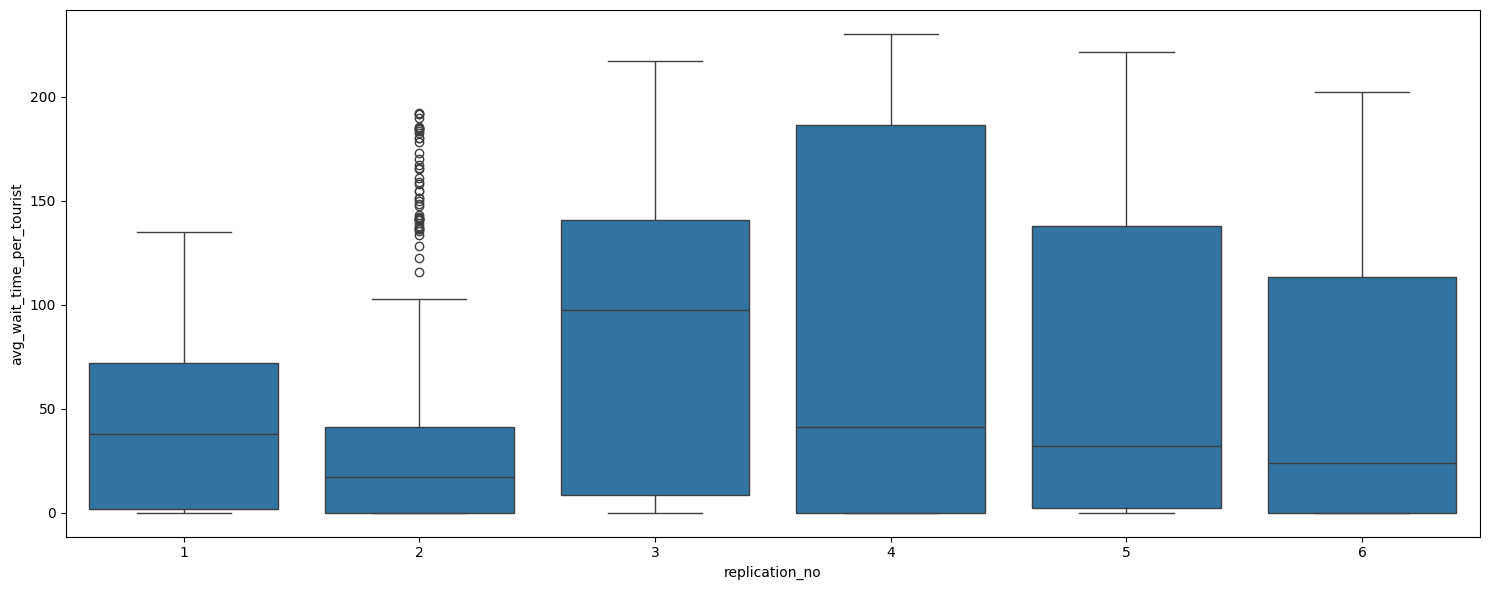

+++--- Quick Summary ---+++
Best Case Scenario:
    Minimum avg waiting time: 0.0 mins at Replication 1
Worst Case Scenario:
    Maximum avg waiting time: 230.076354 mins at Replication 4
+++--- End of Quick Summary ---+++


In [703]:
# Boxplot of tourists waiting time per replication
plt.figure(figsize=(15, 6))
sns.boxplot(x="replication_no", y="avg_wait_time_per_tourist", data=per_tourist_df)
plt.tight_layout()
plt.show()

print("+++--- Quick Summary ---+++")
print(f"Best Case Scenario:")
print(f"    Minimum avg waiting time: {min_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins at Replication {min_wait_time_row['replication_no'].values[0]}")
print(f"Worst Case Scenario:")
print(f"    Maximum avg waiting time: {max_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins at Replication {max_wait_time_row['replication_no'].values[0]}")
print("+++--- End of Quick Summary ---+++")


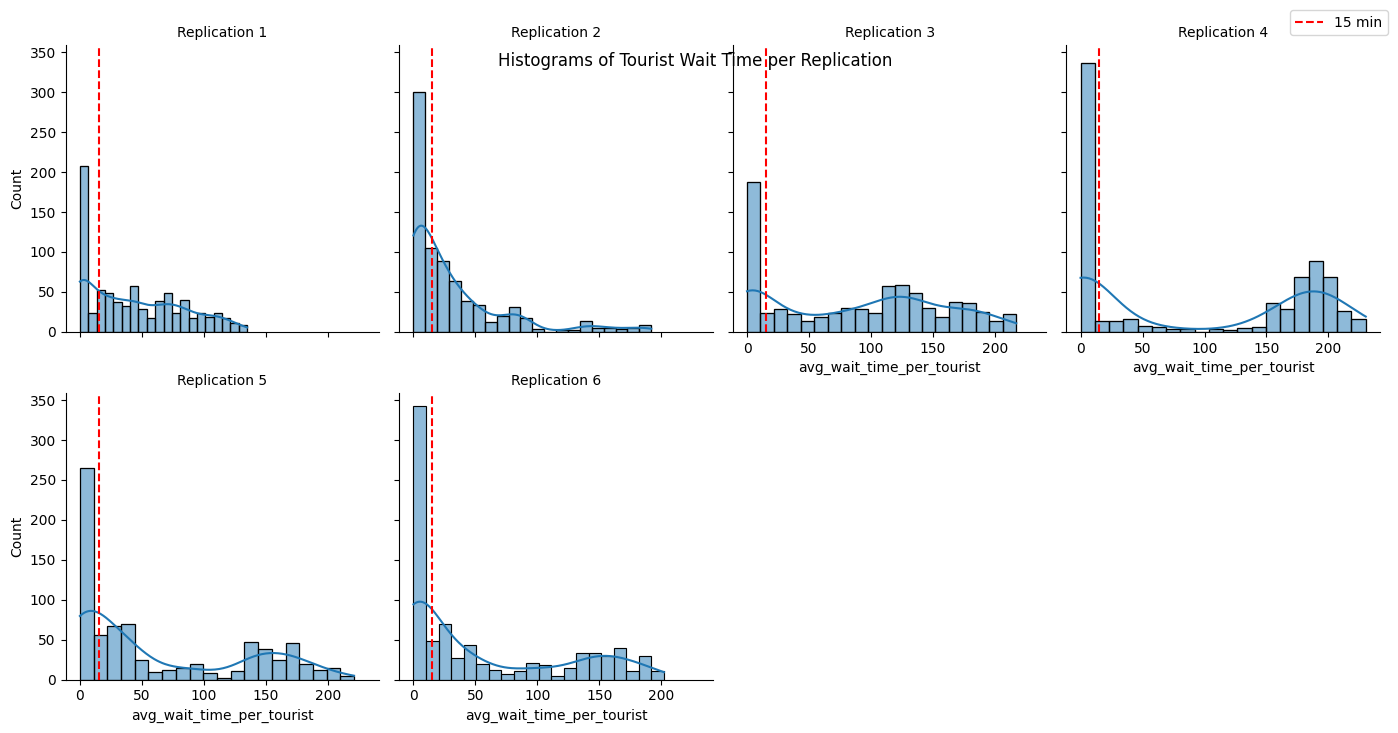

In [704]:
# Custom plot function with 15min vertical lines
def hist_with_vlines(data, color=None, **kwargs):
    ax = plt.gca()
    sns.histplot(data["avg_wait_time_per_tourist"], bins=20, kde=True, ax=ax, color=color)
    ax.axvline(15, color='red', linestyle='--', label='15 min')
    ax.legend(loc='upper right', fontsize='small')

# Create the FacetGrid
g = sns.FacetGrid(per_tourist_df, col="replication_no", col_wrap=4, height=3.5, sharex=True, sharey=True)

# Apply the custom plotting function to each facet
g.map_dataframe(hist_with_vlines)

# Add a 1 hour legend manually
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1, 1.05))

# Titles and layout
g.set_titles("Replication {col_name}")
g.fig.subplots_adjust(top=0.99)
g.fig.suptitle("Histograms of Tourist Wait Time per Replication")

plt.show()

In [705]:
# Get the mean waiting time per replication
replication_means = per_replication_stats["avg_wait_time_per_tourist"]
replication_means

replication_no
1    43.302660
2    30.757638
3    87.989360
4    89.898632
5    62.775850
6    55.598646
Name: avg_wait_time_per_tourist, dtype: float64

### Point and interval estimates

#### 1. Point Estimate Calculations

In [706]:
# Mean (Point Estimate)
wait_time_mean = replication_means.mean()
wait_time_mean
print(f"Mean Waiting Time: {wait_time_mean} mins")

Mean Waiting Time: 61.72046435550641 mins


In [707]:
# Variance (Point Estimate)
wait_time_variance = replication_means.var()
wait_time_variance
print(f"Variance of Waiting Time: {wait_time_variance} mins^2")

Variance of Waiting Time: 564.1133350780015 mins^2


#### 2. Confidence Interval

In [708]:
# 95% CI
alpha = 0.05
confidence_level = 1 - alpha
# Calculate confidence interval with 95% confidence level
confidence_interval, mean_x, std_s, t_crit, margin = compute_confidence_interval(replication_means, confidence_level)

Sample Mean: 61.72046435550641
Sample Std Dev: 23.751070188056822
t-critical (95%): 2.570581835636314
Margin of Error: 24.925219541017842
Confidence Interval: (36.79524481448857, 86.64568389652425)


### Hypothesis Testing

Both directions of hypothesis testing — **proving ≤ 15 mins** and **ensuring it’s not > 15 mins**:

### 💡 TL;DR
- We **cannot claim** that our system is **statistically better than 15 mins**.
- But we **can safely say** it’s **not proven to be worse** than 15 mins either.

In [709]:
# Hypothesis Test:
# H0: mu <= 15 (average wait time is acceptable)
# H1: mu > 15 (average wait time is too high)

mu_0 = 15  # Target threshold for average waiting time
n = len(replication_means)
df = n - 1

# Confidence interval (two-sided)
t_critical_two_sided = t.ppf(1 - alpha/2, df)
margin = t_critical_two_sided * (std_s / np.sqrt(n))
confidence_interval = (mean_x - margin, mean_x + margin)

# One-sided left-tailed test: H0: mu >= 15 vs H1: mu < 15 (prove system is good enough)
t_statistic = (mean_x - mu_0) / (std_s / np.sqrt(n))
t_critical_left = t.ppf(alpha, df)
reject_H0_mu_gte_15 = t_statistic < t_critical_left

# One-sided right-tailed test: H0: mu <= 15 vs H1: mu > 15 (prove system is NOT good enough)
t_critical_right = t.ppf(1 - alpha, df)
reject_H0_mu_lte_15 = t_statistic > t_critical_right

# Dynamic interpretation messages
if reject_H0_mu_gte_15:
    conclusion_left = "✅ There is statistically significant evidence (95% confidence) that the average waiting time is less than 15 minutes."
else:
    conclusion_left = "❌ Cannot conclude with 95% confidence that the average waiting time is less than 15 minutes."

if reject_H0_mu_lte_15:
    conclusion_right = "⚠️ There is statistically significant evidence (95% confidence) that the average waiting time exceeds 15 minutes."
else:
    conclusion_right = "✅ There is no statistical evidence that the average waiting time exceeds 15 minutes."

print("+++--- Hypothesis Test Results ---+++")
print(f"Sample Mean: {mean_x}")
print(f"Sample Std Dev: {std_s}")
print(f"95% CI: {confidence_interval}")
print(f"Margin of Error: {margin}")
print(f"t-statistic: {t_statistic}")
print(f"Left-tailed test H0: μ ≥ 15 → H1: μ < 15")
print(f"    t-critical: {t_critical_left}")
print(f"    Reject H0?: {reject_H0_mu_gte_15}")
print(f"    Conclusion: {conclusion_left}")
print(f"Right-tailed test H0: μ ≤ 15 → H1: μ > 15")
print(f"    t-critical: {t_critical_right}")
print(f"    Reject H0?: {reject_H0_mu_lte_15}")
print(f"    Conclusion: {conclusion_right}")
print("+++--- End of Hypothesis Test Results ---+++")

+++--- Hypothesis Test Results ---+++
Sample Mean: 61.72046435550641
Sample Std Dev: 23.751070188056822
95% CI: (36.79524481448857, 86.64568389652425)
Margin of Error: 24.925219541017842
t-statistic: 4.8183638594283895
Left-tailed test H0: μ ≥ 15 → H1: μ < 15
    t-critical: -2.0150483733330233
    Reject H0?: False
    Conclusion: ❌ Cannot conclude with 95% confidence that the average waiting time is less than 15 minutes.
Right-tailed test H0: μ ≤ 15 → H1: μ > 15
    t-critical: 2.0150483733330233
    Reject H0?: True
    Conclusion: ⚠️ There is statistically significant evidence (95% confidence) that the average waiting time exceeds 15 minutes.
+++--- End of Hypothesis Test Results ---+++


So then **how many replications** you'd need to prove **μ < 15** with desired accuracy (e.g., ±1 min)?

In [710]:
# Parameters
epsilon = 1  # desired margin of error (±1 min)
confidence = confidence_level
Z_alpha_2 = norm.ppf(1 - (1 - confidence)/2)  # Z for two-tailed 95% CI ~ 1.96

# Using the sample standard deviation from the 50-replication run
S = std_s

# Required sample size (replications) using normal approximation:
# R ≥ (Z * S / ε)^2
required_replications = (Z_alpha_2 * S / epsilon) ** 2

required_replications_rounded = int(np.ceil(required_replications))

print("+++--- Required Replications ---+++")
print("Desired Accuracy (±ε):", epsilon)
print("Z-critical (95%):", Z_alpha_2)
print("Sample Std Dev (S):", S)
print("Required Replications (rounded up):", required_replications_rounded)
print("+++--- End of Required Replications ---+++")
print("** Final Conclusion: **")
print(f"    We would need at least {required_replications_rounded} replications to prove μ < 15 with desired accuracy (±1 min).")

+++--- Required Replications ---+++
Desired Accuracy (±ε): 1
Z-critical (95%): 1.959963984540054
Sample Std Dev (S): 23.751070188056822
Required Replications (rounded up): 2168
+++--- End of Required Replications ---+++
** Final Conclusion: **
    We would need at least 2168 replications to prove μ < 15 with desired accuracy (±1 min).


#### Overal Final Output Data Analysis Stats

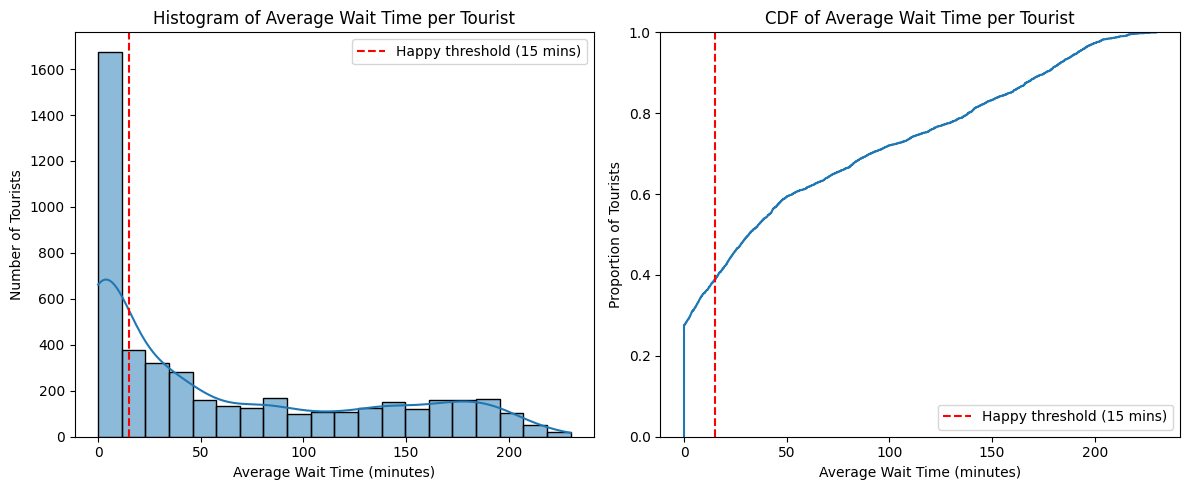

+++--- Output Data Analysis ---+++
--------------------------------
Summary Average Wait Time of the our model:
--------------------------------
Maximum Waiting Time: 230.076354 mins (3.83 hrs) at Replication 4
Point Estimates:
    Sample Std Dev: 23.751070188056822
    Sample Mean: 61.72046435550641
Interval Estimates:
    t-critical (95%): 2.570581835636314
    Margin of Error: 24.925219541017842
    Confidence Interval: (36.79524481448857, 86.64568389652425)
Customer Satisfaction:
    % Happy Tourists (<15 mins): 38.78%
    % Unhappy Tourists (>60 mins): 38.37%
--------------------------------
Hypothesis Test Results:
--------------------------------
    t-statistic: 4.8183638594283895
    Left-tailed test H0: μ ≥ 15 → H1: μ < 15
        t-critical: -2.0150483733330233
        Reject H0?: False
        Conclusion: ❌ Cannot conclude with 95% confidence that the average waiting time is less than 15 minutes.
    Right-tailed test H0: μ ≤ 15 → H1: μ > 15
        t-critical: 2.0150483733

In [711]:
# happy tourists
happy_pct = per_tourist_df["avg_wait_time_per_tourist"].lt(15).mean() * 100
over_60_pct = per_tourist_df["avg_wait_time_per_tourist"].gt(60).mean() * 100

plot_wait_distributions(per_tourist_df)

# 80% happy tourists
required_happy_pct = 80

# Costs (per unit)
bicycle_cost = 80
dock_cost = 100

# Current System
current_system_bicycle_count = 80
current_system_dock_count = 80
current_system_cost = current_system_bicycle_count * bicycle_cost + current_system_dock_count * dock_cost

# Our System
our_system_bicycle_count = bicycle_count
our_system_dock_count = dock_count
our_system_cost = our_system_bicycle_count * bicycle_cost + our_system_dock_count * dock_cost

# Additional Cost
additional_cost = (our_system_bicycle_count - current_system_bicycle_count) * bicycle_cost + (our_system_dock_count - current_system_dock_count) * dock_cost
total_cost = current_system_cost + additional_cost

print("+++--- Output Data Analysis ---+++")
print("--------------------------------")
print("Summary Average Wait Time of the our model:")
print("--------------------------------")
print(f"Maximum Waiting Time: {max_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins ({round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] / 60, 2)} hrs) at Replication {max_wait_time_row['replication_no'].values[0]}")
print("Point Estimates:")
print(f"    Sample Std Dev: {std_s}")
print(f"    Sample Mean: {mean_x}")
print("Interval Estimates:")
print(f"    t-critical (95%): {t_crit}")
print(f"    Margin of Error: {margin}")
print(f"    Confidence Interval: {confidence_interval}")
print("Customer Satisfaction:")
print(f"    % Happy Tourists (<15 mins): {round(happy_pct, 2)}%")
print(f"    % Unhappy Tourists (>60 mins): {round(over_60_pct, 2)}%")
print("--------------------------------")
print("Hypothesis Test Results:")
print("--------------------------------")
print(f"    t-statistic: {t_statistic}")
print(f"    Left-tailed test H0: μ ≥ 15 → H1: μ < 15")
print(f"        t-critical: {t_critical_left}")
print(f"        Reject H0?: {reject_H0_mu_gte_15}")
print(f"        Conclusion: {conclusion_left}")
print(f"    Right-tailed test H0: μ ≤ 15 → H1: μ > 15")
print(f"        t-critical: {t_critical_right}")
print(f"        Reject H0?: {reject_H0_mu_lte_15}")
print(f"        Conclusion: {conclusion_right}")
print("--------------------------------")
print("Required Replications:")
print("--------------------------------")
print(f"    Desired Accuracy (±ε): {epsilon} mins")
print(f"    Z-critical (95%): {Z_alpha_2}")
print(f"    Sample Std Dev (S): {S} mins")
print(f"    Required Replications (rounded up): {required_replications_rounded} for 95% confidence")
print("--------------------------------")
print(f"Cost Analysis: *** Additional Cost: ${additional_cost:,} ***")
print("--------------------------------")
print(f"    Total Bicycles: {bicycle_count}")
print(f"    Total Docks: {dock_count}")
print(f"    Current System Cost: ${current_system_cost:,}")
print(f"    Our System Cost: ${our_system_cost:,}")
print("--------------------------------")
print("+++--- End of Output Data Analysis ---+++")
print("")

#### Final Result & Conclusion

In [712]:
print("*** Result ***")
print(f"Total Cost of ${total_cost:,} with {bicycle_count} bicycles and {dock_count} docks")
print(f"Current System Analysis:")
if current_system_bicycle_count > bicycle_count:
    print(f"    we have removed {current_system_bicycle_count - bicycle_count} bicycles from the system, resulting in ${(current_system_bicycle_count - bicycle_count) * bicycle_cost} saved")
else:
    print(f"    we have added {bicycle_count - current_system_bicycle_count} bicycles to the system, resulting in ${(bicycle_count - current_system_bicycle_count) * bicycle_cost} of additional cost")
if current_system_dock_count > dock_count:
    print(f"    we have removed {current_system_dock_count - dock_count} docks from the system, resulting in ${(current_system_dock_count - dock_count) * dock_cost} saved")
else:
    print(f"    we have added {dock_count - current_system_dock_count} docks to the system, resulting in ${(dock_count - current_system_dock_count) * dock_cost} of additional cost")

print(f"Achieved Happy Percentage: {round(happy_pct, 2)}%")
if happy_pct >= required_happy_pct:
    print(f"    So, we have already achieved {round(happy_pct, 2)}% happy tourists!! Hurray!!")
else:
    print(f"    So, we need to reduce additional {round(required_happy_pct - happy_pct, 2)}% of tourists waiting time to achieve {required_happy_pct}% happy tourists")

print(f"Max Waiting Time: {max_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins ({round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] / 60, 2)} hrs) at Replication {max_wait_time_row['replication_no'].values[0]}")
if max_wait_time_row['avg_wait_time_per_tourist'].values[0] > 60:
    print(f"    Current System is NOT satisfactory!")
    print(f"    So, we need to reduce the max waiting time by {round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] - 60, 2)} mins")
else:
    print(f"    Current System is satisfactory!!!")
    print(f"    So, we need to reduce the max waiting time by {round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] - 60, 2)} mins")

print("*** End of Result ***")


*** Result ***
Total Cost of $14,400 with 80 bicycles and 80 docks
Current System Analysis:
    we have added 0 bicycles to the system, resulting in $0 of additional cost
    we have added 0 docks to the system, resulting in $0 of additional cost
Achieved Happy Percentage: 38.78%
    So, we need to reduce additional 41.22% of tourists waiting time to achieve 80% happy tourists
Max Waiting Time: 230.076354 mins (3.83 hrs) at Replication 4
    Current System is NOT satisfactory!
    So, we need to reduce the max waiting time by 170.08 mins
*** End of Result ***
